# Clasificación de imagenes satelitales mediante el algoritmo de Machine Learning - Random Forest
## Sector Embalse Neusa 
### Dirección de Laboratorio e Innovación Ambiental DLIA
#### Modelos Digitales Ambientales

@ Ing. Nicolas Viasus Valero

@ Msc. Julian Segura

Version: 0.1

Fecha: 2023-10-24

Clasificación de imagenes satelitales a partir de datos de entrenamiento por el algoritmo de machine learning Random Forest



Este script esta basado en el codigo realizado por *[Crhis Holden](http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)* y adaptado por *[Florian Beyer](https://github.com/florianbeyer/RandomForest-Classification/blob/master/Classification_script.ipynb)*


----


## Sección - Librerias y datos de ingreso

En esta sección se definen los datos de ingreso y parametros basicos para realizar el algoritmo *Random Forest* a partir de datos de entrenamiento y testeo sobre imagenes satelitales.

In [1]:
# Importar Librerias requeridas
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr, gdal_array 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import seaborn as sn
import datetime

# Configuración de la libreria GDAL, activar excepciones y drivers
gdal.UseExceptions()
gdal.AllRegister()

In [21]:
# definir el numero de arboles de desición a usar
est = 500


# definir la cantidad de nucleos a usar por defecto -1 usa todos los nucleos dispobibles
n_cores = -1


# Dirección de almacenamiento de la imagen a clasificar
img_RS = r"E:\TOPOGRAFIA\MDA\Proyecto Retamo\Codigo_RF\Neusa.tif"

# Dirección de almacenamiento de los datos de entrenamiento y testeo
path=r"E:\TOPOGRAFIA\MDA\Proyecto Retamo\Codigo_RF"

# Nombre del atributo en los datos de entrenamiento
attribute = 'Class'

# dirección donde se almacenara la imagen clasificada
classification_image = path+"\\classifed.tif"

# dirección donde se almacenaran los registros y resultados del procesamiento
results_txt = path+"\\results.txt"

***
## Sección - Preprocesamiento de datos 

#### Segmentación datos de entrenamiento en *trainging data* (Entrenamiento) y *Testing data* (datos de comprobación)

Los datos de entrenamiento inicialmente se deben segmentar para contar con un porcentaje de dichos datos para validar la exactitud y precisión del algoritmo, para ello se segmentan los datos al 70% en donde el 70% de los datos se usaran para entrenar el algoritmo *Random Forest* y el 30% para validar la precisión y exactitud del modelo

In [22]:
# Dividir los datos de entrenamiento entre entrenamiento y validación o test y almacenarlos en un nuevo archivo shapefile
# Leer shapefile con los datos de entrenamiento
gdf=gpd.read_file(path+"\\Entrenamiento\\Entrenamiento.shp")

#Segmentar los datos en un 70% para entrenamiento y un 30% para testeo
gdf_train = gdf.sample(frac=0.7)
gdf_test = gdf.drop(gdf_train.index)
print('Datos de entrenamiento', gdf.shape, 'training data:', gdf_train.shape, 'testing data:', gdf_test.shape)
gdf_train.to_file(path+"\\Entrenamiento\\train.shp")
gdf_test.to_file(path+"\\Entrenamiento\\test.shp")

#Definir variables de entrenamiento (Training) y validación (testing data)
training = path+"\\Entrenamiento\\train.shp"
validation = path+"\\Entrenamiento\\test.shp"

Datos de entrenamiento (70, 3) training data: (49, 3) testing data: (21, 3)


In [23]:
# Cargar datos de entrenamiento (training data) y mostrar los atritubos del archivo

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extraer los atributos (fieldnames) en el archivo shapefile
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# mostrar atributos 
print('Atributos disponibles en datos de entrenamiento: {}'.format(attributes))

Atributos disponibles en datos de entrenamiento: ['Class', 'Cobertura']


#### Preparar el archivo log de resultados
Aca se mostraran los resultados del procesamiento y se almacenaran en un archivo de texto

In [24]:
# preparar el archivo de texto

print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))


#### Leer metadatos de la imagen satelital
En esta sección se lee la imagen satelital a clasificar mediante la libreria *GDAL* en donde se muestra la extensión de la imagen *(Ancho x largo)* y el numero de bandas

In [25]:
# Leer metadatos de la imagen satelital

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [26]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Extensión de la imagen : {} x {} (row x col)'.format(row, col))
print('Numbero de Bandas: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Numero de Bandas: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))

Extensión de la imagen : 5276 x 5339 (row x col)
Numbero de Bandas: 8


#### Cargar los datos de entrenamiento (Training data) 

Se deben cargar los datos de entrenamiento previamente segmentados y almacenados en el archivo *shp*, para ello se hace uso de la libreria *OGR* y *GDAL* en donde posteriormente se rasterizan estos datos para poder interpretarlos de manera matricial y que sean compatibles con la imagen satelital 

In [27]:
# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()

#### Visualización Imagen satelital Vs Datos de Entrenamiento
Se visualizaran la imagen satelital mediante la banda 8 correspondiente al infrarrojo cercano 2 **NIR2** y los datos de entrenamiento que anteriormente se cargaron y rasterizaron

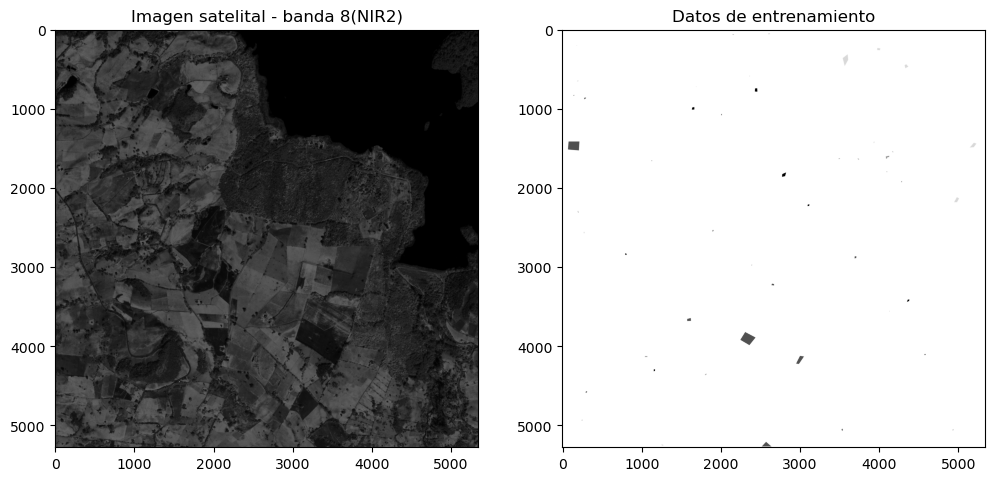

69410 muuestras de entrenamiento
Los datos de entrenamiento incluyen 4 clases: [1 2 3 4]
Tamaño de la matriz X : (69410, 8)
Tamaño de la matriz Y: (69410,)


In [28]:
# Plot imagen satelital y datos de entrenamiento
plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(img[:, :, 7], cmap=plt.cm.Greys_r)
plt.title('Imagen satelital - banda 8(NIR2)')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Greys)
plt.title('Datos de entrenamiento')

plt.show()

# Cantidad de muestrar de entrenamiento:
n_samples = (roi > 0).sum()
print('{n} muuestras de entrenamiento'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# Visualización atributos de los datos de entrenamiento
labels = np.unique(roi[roi > 0])
print('Los datos de entrenamiento incluyen {n} clases: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Mostrar el tamaño del arreglo matricial de la imagen satelital
X = img[roi > 0, :]
y = roi[roi > 0]

print('Tamaño de la matriz X : {sz}'.format(sz=X.shape))
print('Tamaño de la matriz Y: {sz}'.format(sz=y.shape))

*** 
## Sección - Entrenamiento del algoritmo *Random Forest*

#### Entrenamiento del algoritmo
Mediante la libreria *Sklearn* usando el algoritmo **RandomForestClassifier** se definen los hiperparametros del algortimo en donde se debe definir Numero de arboles de desición y numero de nucleos  los cuales se definieron en las variables *est* y *n_cores* respectivamente, adicionalmente se pueden definir otros parametros relevantes como el *oob_score*

***obb_score** metrica para determinar la precisión del algoritmo asumiendo los datos de entrenamiento (Training Data) como datos de validación (testing data); Sirve para contrarestar como se comportó el algortimo respecto a los datos de entrenamiento.*

In [29]:
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)

X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.1s finished


#### Diagnostico del entrenamiento del algoritmo *Random Forest*

Diagnostico del entrenamiento ajustado validando el ***obb_score***

In [30]:
#check out the "Out-of-Bag" (OOB) prediction score:

print('--------------------------------', file=open(results_txt, "a"))
print('TRAINING and RF Model Diagnostics:', file=open(results_txt, "a"))
print('Precisión de la predicción OOB: {oob}%'.format(oob=rf.oob_score_ * 100))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))

Precisión de la predicción OOB: 99.82423281947847%


#### Importancia de cada banda en el entrenamiento del algoritmo

Importancia de cada banda en el entrenamiento del algortimo *Random Forest* y matriz de confusión respecto a los datos de entrenamiento

In [91]:
# Importancia de cada banda:
bands = range(1,img_ds.RasterCount+1)

for b, imp in zip(bands, rf2.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    print('Band {b} importance: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))


# Let's look at a crosstabulation to see the class confusion. 
# To do so, we will import the Pandas library for some help:
# Setup a dataframe -- just like R
# Exception Handling because of possible Memory Error

try:
    df = pd.DataFrame()
    df['truth'] = y
    df['predict'] = rf.predict(X)

except MemoryError:
    print('Crosstab not available ')

else:
    # Cross-tabulate predictions
    #print(pd.crosstab(df['truth'], df['predict'], margins=True))
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))

Band 1 importance: 0.03860383746906171
Band 2 importance: 0.06294143133316218
Band 3 importance: 0.18783071533831186
Band 4 importance: 0.19032032453780284
Band 5 importance: 0.14641807405285093
Band 6 importance: 0.12817680276749674
Band 7 importance: 0.0782999936678202
Band 8 importance: 0.16740882083349365


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    0.6s finished


#### Matriz de confusión entrenamiento del algoritmo

Matriz de confusión sobre los datos de entrenamiento del algoritmo *Random Forest*

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    0.6s finished


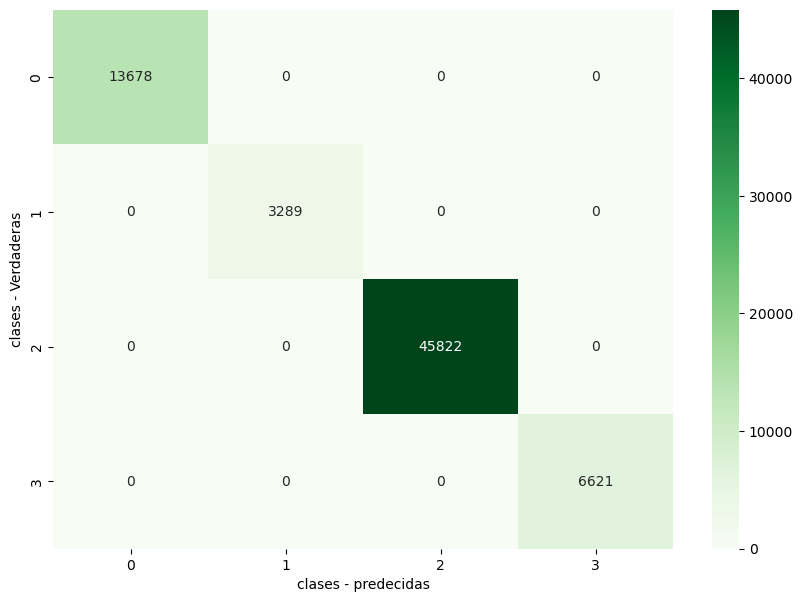

In [92]:
cm = confusion_matrix(y,rf.predict(X))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g',cmap='Greens')
plt.xlabel('clases - predecidas')
plt.ylabel('clases - Verdaderas')
plt.show()

***
## Sección - Predicción de la imagen satelital

Una vez realizado el entrenamiento del algortimo, se debe predecir el resto de la imagen satelital. Para ello inicialmente se debe re escalar la imagen satelital en un arreglo 2D. 

In [33]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (5276, 5339, 8) to (28168564, 8)


C:\Users\NicolasViasus\.conda\envs\mda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


A continuación se precide la totalidad de la imagen satelital mediante la libreria *Sklearn* usando el algoritmo ***predict***, en donde se procedera a determinar cada clase para cada pixel dentro de la imagen satelital. Debido a que es un procesamiento que implica una alta capacidad computacional, se creó un bucle *while* para realizar el procesamiento en sub imagenes y al finalizar cada sub imagen las uniera nuevamente en una sola

In [34]:
# Predicción sobre toda la imagen satelital.
#Si no hay suficiente memoria RAM, se dividira la imagen para poder llevar a cabo el procesamiento
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round(len(img_as_array)/1000))

    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, derzeit: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = slices/2
            print('Memoria RAM insuficiente, Cantidad slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Predicción de la imagen satisfactoria sin nececidad de sub-imagenes')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   23.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  4.8min finished


Predicción de la imagen satisfactoria sin nececidad de sub-imagenes


In [36]:
# concatenar todas las subimagenes y re escalarlas nuevamente.
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No Sub imagenes necesarias!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Re escalado de la imagen original {}'.format(class_prediction.shape))

No Sub imagenes necesarias!
Re escalado de la imagen original (5276, 5339)


#### Visualización de la imagen clasificada


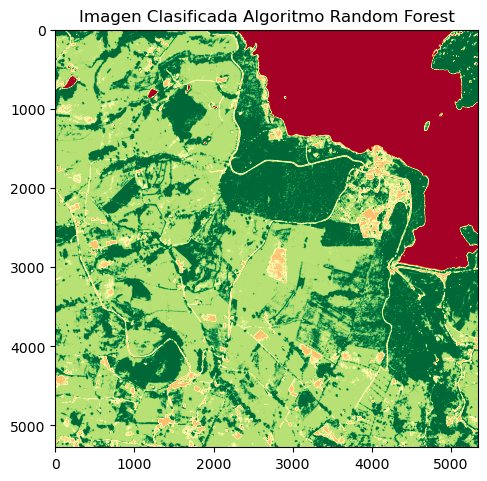

In [37]:
#Plot image classification
class_prediction.astype(np.float16)
plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.RdYlGn)
plt.title('Imagen Clasificada Algoritmo Random Forest')

plt.show()

#### Almacenamiento en disco de la imagen clasificada

In [38]:
cols = img.shape[1]
rows = img.shape[0]

class_prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction)
outdata.FlushCache() ##saves to disk!!
print('Imagen guardada en: {}'.format(classification_image))

Imagen guardada en: E:\TOPOGRAFIA\MDA\Proyecto Retamo\Codigo_RF\classifed.tif


***
## Sección - Validación y precisión del algoritmo para la imagen clasificada

#### Visualización de la imagen original Vs imagen clasificada, datos de entrenamiento y testing 


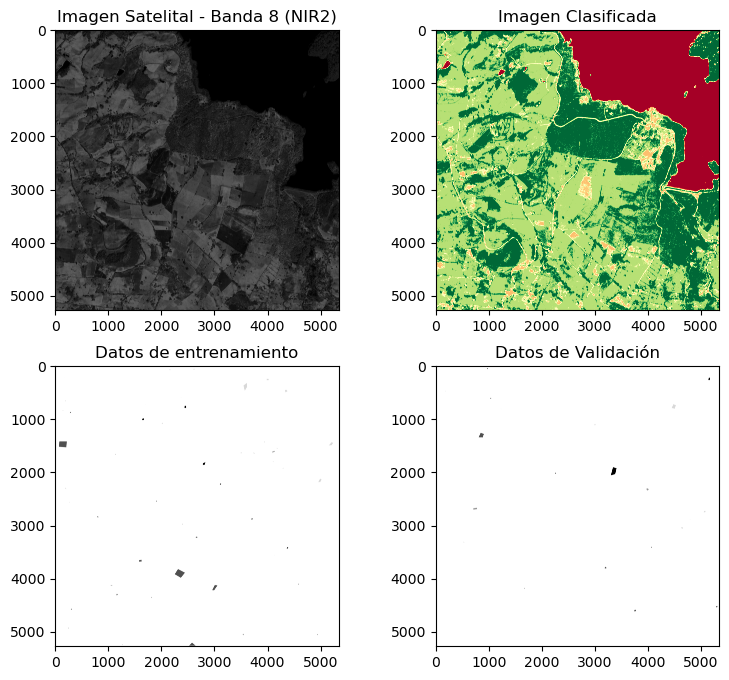

In [39]:
# validación/ accuracy assessment

# preparando archivo de texto

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# Plot
plt.figure(figsize=(9,8))
plt.subplot(221)
plt.imshow(img[:, :, 7], cmap=plt.cm.Greys_r)
plt.title('Imagen Satelital - Banda 8 (NIR2)')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.RdYlGn)
plt.title('Imagen Clasificada')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Greys)
plt.title('Datos de entrenamiento')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Greys)
plt.title('Datos de Validación')

plt.show()

#### Precisión del algoritmo ***Random Forest*** 

La imagen clasificada debe ser validada y contrastada respecto a los datos de testeo (Testing Data). En este proceso se consigue obtener que tan exacto fue la clasificación de la imagen, el OBB score y la matriz de confusión, la cual permite identificar los valores predecidos respecto a los valores reales según los datos de testeo (Testing Data). 

***Accuracy**: Representa el porcentaje total de valores correctamente clasificados. indica una medida de exactitud optima para cuando el conjunto de datos se encuentra balanceado*

***Precisión**: Representa el porcentaje de valores que se han clasificado en una clase y que realmente pertenecen a dicha clase* 

***recall**: Representa el porcentaje de valores identificados correctamente para determinada cobertura del total de dicha coberturade valores reales*

***F1-Score**: Es la media armonica de la **precisión** y el **recall***

In [42]:
# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} Pixeles de validación (Testing data)'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('Datos de validación incluyen {n} clases: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Tamaño de la matriz X: {sz_v}'.format(sz_v=X_v.shape))
print('Tanaño de la matriz Y: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
#print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))


# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

30785 Pixeles de validación (Testing data)
Datos de validación incluyen 4 clases: [1 2 3 4]
Tamaño de la matriz X: (30785,)
Tanaño de la matriz Y: (30785,)
              precision    recall  f1-score   support

           1       0.98      1.00      0.99      5618
           2       0.96      1.00      0.98      4310
           3       0.97      0.94      0.96      8742
           4       0.97      0.97      0.97     12115

    accuracy                           0.97     30785
   macro avg       0.97      0.98      0.97     30785
weighted avg       0.97      0.97      0.97     30785

OAA = 97.08949163553679 %


#### Matriz de confusión

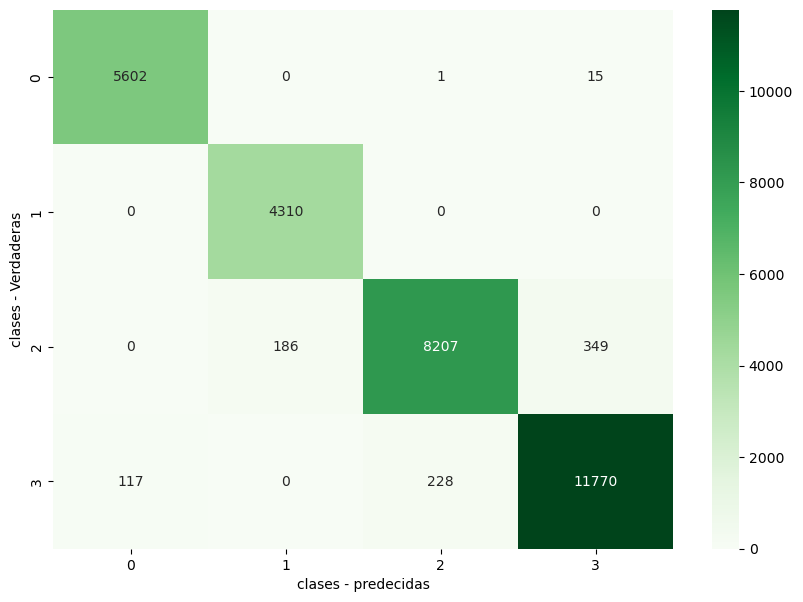

In [41]:
cm_val = confusion_matrix(roi_v[roi_v > 0],class_prediction[roi_v > 0])
plt.figure(figsize=(10,7))
sn.heatmap(cm_val, annot=True, fmt='g',cmap='Greens')
plt.xlabel('clases - predecidas')
plt.ylabel('clases - Verdaderas')
plt.show()

***
### Sección - Analisis de resultados

* De acuerdo a los datos de entrenamiento *(Training Data)* El modelo tuvo un desempeño **(OBB) del 99.82%**; Es decir, el 99.82% de las veces el algoritmo asigno una clase a la cobertura adecuada indicando un entrenamiento del algoritmo suficientemente alto.
* La exactitud del modelo fue de **97% (Accuracy)** indicando que el 97% de las veces el modelo asigno una cobertura correctamente.
* La precisión para todas las categorias fue superior al **96%** mientras que el recall fue superior al **94%** indicando una correlación entre los valores clasificados correctamente y los valores predecidos correctamente.
* El **F1-Score** representa en terminos generales un porcentaje superior al **96%**.

Los valores de las clases y su respectiva cobertura se muestran en la siguiente clase:


In [90]:
Clases=gdf.pivot_table(index=["Class","Cobertura"],aggfunc='size')
Clases=Clases.reset_index()
Clases=Clases.rename(columns={0:'Total'})
Clases

,Class,Cobertura,Total
0,1,Cuerpo de agua,15
1,2,Infraestructura,20
2,3,Vegetación baja,18
3,4,Bosque,17
